# VAE for MNIST clustering and generation

The goal of this notebook is to explore some recent works dealing with variational auto-encoder (VAE).

We will use MNIST dataset and a basic VAE architecture. 

In [1]:
# http://pytorch.org/
from os import path
from wheel.pep425tags import get_abbr_impl, get_impl_ver, get_abi_tag
platform = '{}{}-{}'.format(get_abbr_impl(), get_impl_ver(), get_abi_tag())

accelerator = 'cu80' if path.exists('/opt/bin/nvidia-smi') else 'cpu'

!pip install -q http://download.pytorch.org/whl/{accelerator}/torch-0.4.1-{platform}-linux_x86_64.whl torchvision

tcmalloc: large alloc 1073750016 bytes == 0x570b8000 @  0x7fb538bfb2a4 0x594e17 0x626104 0x51190a 0x4f5277 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x510c78 0x5119bd 0x4f5277 0x4f3338 0x510fb0 0x5119bd 0x4f6070 0x4f3338 0x510fb0 0x5119bd 0x4f6070


In [2]:
import torch
print(torch.__version__)
print(accelerator)

0.4.1
cu80


In [0]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision import transforms
from torchvision.utils import save_image

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.metrics.cluster import normalized_mutual_info_score

def show(img):
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')

In [0]:
# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Create a directory if not exists
sample_dir = 'samples'
if not os.path.exists(sample_dir):
    os.makedirs(sample_dir)

In [5]:
batch_size = 128
#to be modified
data_dir = '/home/mlelarge/data'
# MNIST dataset
dataset = torchvision.datasets.MNIST(root=data_dir,
                                     train=True,
                                     transform=transforms.ToTensor(),
                                     download=True)

# Data loader
data_loader = torch.utils.data.DataLoader(dataset=dataset,
                                          batch_size=batch_size, 
                                          shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST(data_dir, train=False, download=True, transform=transforms.ToTensor()),
    batch_size=10, shuffle=False)

Processing...
Done!


# Variational Autoencoders

Consider a latent variable model with a data variable $x\in \mathcal{X}$ and a latent variable $z\in \mathcal{Z}$, $p(z,x) = p(z)p_\theta(x|z)$. Given the data $x_1,\dots, x_n$, we want to train the model by maximizing the marginal log-likelihood:
\begin{eqnarray*}
\mathcal{L} = \mathbf{E}_{p_d(x)}\left[\log p_\theta(x)\right]=\mathbf{E}_{p_d(x)}\left[\log \int_{\mathcal{Z}}p_{\theta}(x|z)p(z)dz\right],
  \end{eqnarray*}
  where $p_d$ denotes the empirical distribution of $X$: $p_d(x) =\frac{1}{n}\sum_{i=1}^n \delta_{x_i}(x)$.

 To avoid the (often) difficult computation of the integral above, the idea behind variational methods is to instea maximize a lower bound to the log-likelihood:
  \begin{eqnarray*}
\mathcal{L} \geq L(p_\theta(x|z),q(z|x)) =\mathbf{E}_{p_d(x)}\left[\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]-\mathrm{KL}\left( q(z|x)||p(z)\right)\right].
  \end{eqnarray*}
  Any choice of $q(z|x)$ gives a valid lower bound. Variational autoencoders replace the variational posterior $q(z|x)$ by an inference network $q_{\phi}(z|x)$ that is trained together with $p_{\theta}(x|z)$ to jointly maximize $L(p_\theta,q_\phi)$. The variational posterior $q_{\phi}(z|x)$ is also called the encoder and the generative model $p_{\theta}(x|z)$, the decoder or generator.

The first term $\mathbf{E}_{q(z|x)}\left[\log p_\theta(x|z)\right]$ is the negative reconstruction error. Indeed under a gaussian assumption i.e. $p_{\theta}(x|z) = \mathcal{N}(\mu_{\theta}(z), 1)$ the term $\log p_\theta(x|z)$ reduced to $\propto \|x-\mu_\theta(z)\|^2$, which is often used in practice. The term $\mathrm{KL}\left( q(z|x)||p(z)\right)$ can be seen as a regularization term, where the variational posterior $q_\phi(z|x)$ should be matched to the prior $p(z)= \mathcal{N}(0,1)$.

Variational Autoencoders were introduced by [Kingma and Welling](https://arxiv.org/abs/1312.6114), see also [Doersch](https://arxiv.org/abs/1606.05908) for a tutorial.

There are vairous examples of VAE in pytorch available [here](https://github.com/pytorch/examples/tree/master/vae) or [here](https://github.com/yunjey/pytorch-tutorial/blob/master/tutorials/03-advanced/variational_autoencoder/main.py#L38-L65). The code below is taken from this last source.

In [0]:
# Hyper-parameters
image_size = 784
h_dim = 400
z_dim = 20
num_epochs = 15
learning_rate = 1e-3

# VAE model
class VAE(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20):
        super(VAE, self).__init__()
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        
        self.fc4 = nn.Linear(z_dim, h_dim)
        self.fc5 = nn.Linear(h_dim, image_size)
        
    def encode(self, x):
        h = F.relu(self.fc1(x))
        return self.fc2(h), self.fc3(h)
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z):
        h = F.relu(self.fc4(z))
        return torch.sigmoid(self.fc5(h))
    
    def forward(self, x):
        mu, log_var = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z)
        return x_reconst, mu, log_var

model = VAE().to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

Here for the loss, instead of MSE for the reconstruction loss, we take BCE. The code below is still from the pytorch tutorial (with minor modifications to avoid warnings!).

In [0]:
# Start training
for epoch in range(num_epochs):
    for i, (x, _) in enumerate(data_loader):
        # Forward pass
        x = x.to(device).view(-1, image_size)
        x_reconst, mu, log_var = model(x)
        
        # Compute reconstruction loss and kl divergence
        # For KL divergence, see Appendix B in VAE paper
        reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
        kl_div = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
        
        # Backprop and optimize
        loss = reconst_loss + kl_div
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
        if (i+1) % 10 == 0:
            print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}" 
                   .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size, kl_div.item()/batch_size))

Let see how our network reconstructs our last batch. We display pairs of original digits and reconstructed version.

In [0]:
mu, _ = model.encode(x) 
out = model.decode(mu)
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

Let see now, how our network generates new samples.

In [0]:
with torch.no_grad():
        z = torch.randn(16, z_dim).to(device)
        out = model.decode(z).view(-1, 1, 28, 28)

out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

Not great, but we did not train our network for long... That being said, we have no control of the generated digits. In the rest of this jupyter, we explore ways to generates zeros, ones, twos and so on. As a by product, we show how our VAE will allow us to do clustering.

The main idea is to build what we call a Gumbel VAE as described below.

# Gumbel VAE

Implement a VAE where you add a categorical variable $c\in \{0,\dots 9\}$ so that your latent variable model is $p(c,z,x) = p(c)p(z)p_{\theta}(x|,c,z)$ and your variational posterior is $q_{\phi}(c|x)q_{\phi}(z|x)$ as described in this NIPS [paper](https://arxiv.org/abs/1804.00104). Make minimal modifications to previous architecture...

The idea is that you incorporates a categorical variable in your latent space. You hope that this categorical variable will encode the class of the digit, so that your network can use it for a better reconstruction. Moreover, if things work as planed, you will then be able to generate digits conditionally to the class, i.e. you can choose the class thanks to the latent categorical variable $c$ and then generate digits from this class.

As noticed above, in order to sample random variables while still being able to use backpropagation required us to use the reparameterization trick which is easy for Gaussian random variables. For categorical random variables, the reparameterization trick is explained in this [paper](https://arxiv.org/abs/1611.01144). This is implemented in pytorch thanks to [F.gumbel_softmax](https://pytorch.org/docs/stable/nn.html?highlight=gumbel_softmax#torch.nn.functional.gumbel_softmax)

In [0]:
n_classes = 10

class VAE_Gumbel(nn.Module):
    def __init__(self, image_size=784, h_dim=400, z_dim=20, n_classes = 10):
        super(VAE_Gumbel, self).__init__()
        #
        # your code here
        self.fc1 = nn.Linear(image_size, h_dim)
        self.fc2 = nn.Linear(h_dim, z_dim)
        self.fc3 = nn.Linear(h_dim, z_dim)
        
        ## I add a layer to encode the category class
        self.fc4 = nn.Linear(h_dim, n_classes)

        self.fc5 = nn.Linear(z_dim + n_classes, h_dim)
        self.fc6 = nn.Linear(h_dim, image_size)
        #
        
    def encode(self, x):
        #
        # your code here / use F.log_softmax
        h = F.relu(self.fc1(x))
        
        h_1 = self.fc2(h)
        h_2 = self.fc3(h)
        c = self.fc4(h)
        c = F.log_softmax(c, dim=1)
        return h_1, h_2, c
        #
    
    def reparameterize(self, mu, log_var):
        std = torch.exp(log_var/2)
        eps = torch.randn_like(std)
        return mu + eps * std

    def decode(self, z, y_onehot):
        #
        # your code here / use torch.cat
        h = F.relu(self.fc5(torch.cat((z, y_onehot), dim=1)))
        return torch.sigmoid(self.fc6(h))
        #
    
    def forward(self, x):
        #
        # your code here / use F.gumbel_softmax
        mu, log_var, y_onehot = self.encode(x)
        z = self.reparameterize(mu, log_var)
        x_reconst = self.decode(z, F.gumbel_softmax(y_onehot))
        return x_reconst, mu, log_var, y_onehot
        #

model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

You need to modify the loss to take into account the categorical random variable with an uniform prior on $\{0,\dots 9\}$, see Appendix A.2 in the NIPS [paper](https://arxiv.org/abs/1804.00104)

In [0]:
def train_G(model, data_loader=data_loader,num_epochs=num_epochs, beta = 1., verbose=True):
    model.train(True)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            #
            # your code here
            x_reconst, mu, log_var, y_onehot = model(x)
            
            ## Transform labels into one_hot encoding to use as mask for kl_div of y_onehot||labels
            labels_onehot = torch.FloatTensor(labels.size(0), 10)
            labels_onehot.zero_()
            labels_onehot.scatter_(1, labels.view(-1,1), 1)
            # 

            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            #
            # your code here
            kl_div_z = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            ## Like said in the Forum, to minimize KL_div_c we need to minize -log(p(c=i|x))
            ## So i transformed labels into labels_onehot encoding so that the multiplication between y_onehot and labels_onehot
            ## keeps only these -log(p(c=i|x)) and the computation is fast because it is a multiplication
            kl_div_c = - torch.sum(y_onehot * labels_onehot.to(device))
            #
         
            # Backprop and optimize
            loss = reconst_loss + beta * (kl_div_z + kl_div_c) # your code here
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div_z.item()/batch_size, kl_div_c.item()/batch_size))

In [0]:
train_G(model_G,num_epochs=10,verbose=True)

In [0]:
x,_ = next(iter(data_loader))
x = x[:24,:,:,:].to(device)
out, _, _, log_p = model_G(x.view(-1, image_size)) 
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

This was for reconstruction, but we care more about generation. For each category, we are generating 8 samples thanks to the following matrix, so that in the end, we should have on each line only one digit represented.

In [0]:
matrix = np.zeros((8,n_classes))
matrix[:,0] = 1
final = matrix[:]
for i in range(1,n_classes):
    final = np.vstack((final,np.roll(matrix,i)))

In [0]:
with torch.no_grad():
        z = torch.randn(8*n_classes, z_dim).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)

out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

It does not look like our original idea is working...

To check that our network is not using the categorical variable, we can track the [normalized mutual information](http://scikit-learn.org/stable/modules/generated/sklearn.metrics.normalized_mutual_info_score.html) between the true labels and the labels 'predicted' by our network (just by taking the category with maximal probability). Change your training loop to return the normalized mutual information (NMI) for each epoch. Plot the curve to check that the NMI is actually decreasing.

In [0]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

In [0]:
def train_G_NMI(model, data_loader=data_loader,num_epochs=num_epochs, beta = 1.0, verbose=True):
    model.train(True)
    NMI = []
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, y_onehot = model(x)
            
            # Transform labels into one_hot encoding to compare with latent distribution y_onehot
            labels_onehot = torch.FloatTensor(labels.size(0), 10)
            labels_onehot.zero_()
            labels_onehot.scatter_(1, labels.view(-1,1), 1)
            
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div_z = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            kl_div_c = - torch.sum(y_onehot * labels_onehot.to(device))
            
            # Backprop and optimize
            loss = reconst_loss + beta * (kl_div_z + kl_div_c) # your code here
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    NMI_print = normalized_mutual_info_score(labels.detach().cpu().numpy(), torch.max(y_onehot, dim=1)[1].detach().cpu().numpy())
                    NMI.append(NMI_print)
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}, NMI: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div_z.item()/batch_size, kl_div_c.item()/batch_size, NMI_print))
    return NMI

In [0]:
NMI = train_G_NMI(model_G,num_epochs=10,verbose=True)

In [0]:
plt.plot(NMI)

## NMI is increasing but I think it is normal. Because as we can see on the generation image ( the last figure ), 
## we see that 1 is almost recognized ( the second row ) and the other rows are not completely random ( last row looks like 9 ).
## It means that our network learnt some categorical information but it is not enough to have a good generation. Lets see what happen in next section

In order to force our network to use the categorical variable, we will change the loss following this ICLR [paper](https://openreview.net/forum?id=Sy2fzU9gl)

Implement this change in the training loop and plot the new NMI curve after 10 epochs. For $\beta = 20$, you should see that NMI increases. But reconstruction starts to be bad and generation is still poor.

This is explained in this [paper](https://arxiv.org/abs/1804.03599) and a solution is proposed see Section 5. Implement the solution described in Section 3 equation (7) if the NIPS [paper](https://arxiv.org/abs/1804.00104) 

In [0]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)
def train_G_NMI_beta20(model, data_loader=data_loader,num_epochs=num_epochs, beta = 20., verbose=True):
    model.train(True)
    NMI = []
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, y_onehot = model(x)
            
            # Transform labels into one_hot encoding to compare with latent distribution y_onehot
            labels_onehot = torch.FloatTensor(labels.size(0), 10)
            labels_onehot.zero_()
            labels_onehot.scatter_(1, labels.view(-1,1), 1)
            
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div_z = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            kl_div_c = - torch.sum(y_onehot * labels_onehot.to(device))
            
            # Backprop and optimize
            loss = reconst_loss + beta * (kl_div_z + kl_div_c) # your code here
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
            if verbose:
                if (i+1) % 10 == 0:
                    NMI_print = normalized_mutual_info_score(labels.detach().cpu().numpy(), torch.max(y_onehot, dim=1)[1].detach().cpu().numpy())
                    NMI.append(NMI_print)
                   
    plt.plot(NMI)
    plt.show()
    
train_G_NMI_beta20(model_G,num_epochs=10,verbose=True)

Here the NMI is closer to 1 compared to the last one. Hence our network learned more categorical information

In [0]:
x,_ = next(iter(data_loader))
x = x[:24,:,:,:].to(device)
out, _, _, log_p = model_G(x.view(-1, image_size)) 
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

The reconstruction is bad, digits look more like ghost digits

In [0]:
with torch.no_grad():
        z = torch.randn(8*n_classes, z_dim).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)

out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

Generation is quite good but digits still look like ghost digits which is not what we want.

# Solution proposed in Section 5 of NIPS paper

In [0]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)

In [0]:
# proposed value for MNIST in the paper:
# beta = 30
# C_z = 0 to 5 in 25000 iterations
# C_c = 0 to 5 in 25000 iterations

def train_G_modified_loss(model, data_loader=data_loader,num_epochs=num_epochs, beta=30. , C_z_fin=5., C_c_fin=5., verbose=True):
    #
    # your code here
    model.train(True)
    NMI = []
    C_z = 0
    C_c = 0
    C = num_epochs * len(data_loader)
    for epoch in range(num_epochs):
        all_labels = []
        all_labels_est = []
        for i, (x, labels) in enumerate(data_loader):
          
            # Forward pass
            x = x.to(device).view(-1, image_size)
            x_reconst, mu, log_var, y_onehot = model(x)
            
            # Transform labels into one_hot encoding to compare with latent distribution y_onehot
            labels_onehot = torch.FloatTensor(labels.size(0), 10)
            labels_onehot.zero_()
            labels_onehot.scatter_(1, labels.view(-1,1), 1)
            
            
            reconst_loss = F.binary_cross_entropy(x_reconst, x, reduction='sum')
            kl_div_z = - 0.5 * torch.sum(1 + log_var - mu.pow(2) - log_var.exp())
            kl_div_c = - torch.sum(y_onehot * labels_onehot.to(device))
            
            # Backprop and optimize
            loss = reconst_loss + beta * (abs(kl_div_z - C_z)  + abs(kl_div_c - C_c)) # your code here
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            C_z += C_z_fin/C
            C_c += C_c_fin/C
            
            if verbose:
                if (i+1) % 10 == 0:
                    NMI_print = normalized_mutual_info_score(labels.detach().cpu().numpy(), torch.max(y_onehot, dim=1)[1].detach().cpu().numpy())
                    NMI.append(NMI_print)
                    print ("Epoch[{}/{}], Step [{}/{}], Reconst Loss: {:.4f}, KL Div: {:.4f}, Entropy: {:.4f}, NMI: {:.4f}" 
                           .format(epoch+1, num_epochs, i+1, len(data_loader), reconst_loss.item()/batch_size,
                                   kl_div_z.item()/batch_size, kl_div_c.item()/batch_size, NMI_print))
                    
                   
    return NMI
    #

In [0]:
NMI = train_G_modified_loss(model_G,num_epochs=10,verbose=True)

In [0]:
plt.plot(NMI)
plt.show()

In [0]:
with torch.no_grad():
        z = torch.randn(8*n_classes, z_dim).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

In [0]:
i = 1
with torch.no_grad():
    plt.plot()
    z = torch.randn(8, z_dim).to(device)
    y_onehot = torch.tensor(np.roll(matrix,i)).type(torch.FloatTensor).to(device)
    out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
    out_grid = torchvision.utils.make_grid(out).cpu()
    show(out_grid)

In [0]:
x,_ = next(iter(data_loader))
x = x[:24,:,:,:].to(device)
out, _, _, log_p = model_G(x.view(-1, image_size)) 
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

# Custom Solution ( different beta, C_z, C_c ) while keeping epochs to 10 to be comparable

In [47]:
model_G = VAE_Gumbel().to(device)
optimizer = torch.optim.Adam(model_G.parameters(), lr=learning_rate)
NMI = train_G_modified_loss(model_G,num_epochs=10, beta = 4, C_z_fin=5., C_c_fin=10., verbose=True)

Epoch[1/10], Step [10/469], Reconst Loss: 319.0919, KL Div: 7.9159, Entropy: 2.0909, NMI: 0.4566
Epoch[1/10], Step [20/469], Reconst Loss: 246.1782, KL Div: 3.6240, Entropy: 1.9570, NMI: 0.5667
Epoch[1/10], Step [30/469], Reconst Loss: 222.5212, KL Div: 1.8979, Entropy: 1.8466, NMI: 0.6717
Epoch[1/10], Step [40/469], Reconst Loss: 214.5994, KL Div: 1.5086, Entropy: 1.6266, NMI: 0.7246
Epoch[1/10], Step [50/469], Reconst Loss: 209.2282, KL Div: 1.8736, Entropy: 1.2427, NMI: 0.7572
Epoch[1/10], Step [60/469], Reconst Loss: 208.3428, KL Div: 1.8602, Entropy: 1.0526, NMI: 0.6532
Epoch[1/10], Step [70/469], Reconst Loss: 204.4044, KL Div: 1.7307, Entropy: 0.9514, NMI: 0.6853
Epoch[1/10], Step [80/469], Reconst Loss: 198.4633, KL Div: 2.4303, Entropy: 0.6005, NMI: 0.8396
Epoch[1/10], Step [90/469], Reconst Loss: 190.4949, KL Div: 2.9288, Entropy: 0.6597, NMI: 0.7517
Epoch[1/10], Step [100/469], Reconst Loss: 192.3248, KL Div: 2.7293, Entropy: 0.5043, NMI: 0.7974
Epoch[1/10], Step [110/469], 

In [0]:
matrix = np.zeros((8,n_classes))
matrix[:,0] = 1
final = matrix[:]
for i in range(1,n_classes):
    final = np.vstack((final,np.roll(matrix,i)))

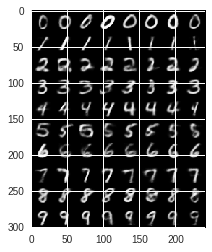

In [49]:
with torch.no_grad():
        z = torch.randn(8*n_classes, z_dim).to(device)
        y_onehot = torch.tensor(final).type(torch.FloatTensor).to(device)
        out = model_G.decode(z,y_onehot).view(-1, 1, 28, 28)
out_grid = torchvision.utils.make_grid(out).cpu()
show(out_grid)

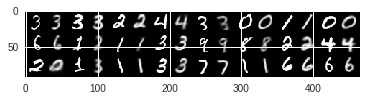

In [50]:
x,_ = next(iter(data_loader))
x = x[:24,:,:,:].to(device)
out, _, _, log_p = model_G(x.view(-1, image_size)) 
x_concat = torch.cat([x.view(-1, 1, 28, 28), out.view(-1, 1, 28, 28)], dim=3)
out_grid = torchvision.utils.make_grid(x_concat).cpu().data
show(out_grid)

I tried different beta, C_z, C_c while keeping epochs to 10. I found that beta = 4., C_z = 5, C_c = 10 is quite alright. We still see that "ghost" effect. These numbers are heuristical because I found them only by looking generation and reconstruction, but for better results we could take into account ours losses and try with several beta, C_z and C_c ( gradually increase from one value to another one ) to get the lowest loss !

The structure of our network is very simple. Indeed, we only use FC layer but we could do Conv and Deconv layers ( because we are working with images ) and these layers take more spatial information which is very good for images.

And In addition, if generation is what we really want, we could use a GAN structure which is very effective these days for generating new images that looks like real !

